Step 1: install All the Required packages

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

#what is peft so peft is parameter_efficient transfer learning for nlp
#what is bitsandbytes : it is used for quantization purpose


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


Step 2: Import All the required Libraries

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In case of Llama 2, the following prompt template is used for the chat models

System Prompt (optional) to guide the model

User prompt (required) to give the instruction

Model Answer (required)

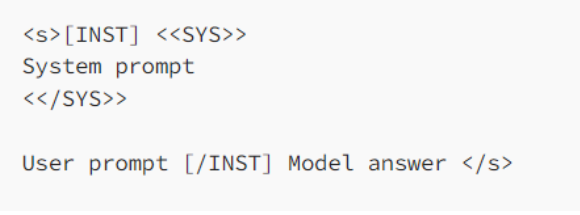

#code to do for sample input from user

In [ ]:
from transformers import LlamaTokenizer, LlamaForCausalLM

# Load the tokenizer and model
tokenizer = LlamaTokenizer.from_pretrained('model_name_or_path')
model = LlamaForCausalLM.from_pretrained('model_name_or_path')

# Define the system prompt and user prompt
system_prompt = "System prompt"
user_prompt = "User prompt"

# Format the input text
input_text = f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{user_prompt} [/INST] "

# Tokenize the input text
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate the model's response
output_ids = model.generate(input_ids)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(output_text)


we will reformate our data set to follow LLama 2 formate

DataSet: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

DataSet Transformer : https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing



Note: How to fine tune Llama 2

-> Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

-> We also need to consider the overhead due to optimizer states, gradients, and forward activations

-> Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

-> To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

Step 3

Load a llama-2-7b-chat-hf model (chat model)

Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune


QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [1]:
#the Modal that you want to train from the hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

#dataSet Name
dataset_name = "mlabonne/guanaco-llama2-1k"

#modal name after fine tune
New_model_name = "Llama-2-7b-chat-finetune"

#QLoRA parameters

#lora dimension
lora_r = 64

#lora scaling parameter
lora_alpha = 16

#Dropout probability for lora layers
lora_dropout = 0.1

#bitandbyste paramter

#active 4 bit precision base model loading
bnb_4bit = True

# compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

#Active nested quantization for 4-bit base models(double quantization)
use_nested_quant = True

## TrainingArguments paramaters

#out directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to true with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

#Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.35

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay if we apply to all layers
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "consine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

#Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25


## SFt parameters

# Maximum sequence length to use
max_seq_length = None

#pack multiple short examples in the same input sequence to increase efficiency
#to reduce memory usage
packing = False

#load the entire model on the gpu 0
device_map = {"",0}







Step 4: Load everything and start the fine-tuning process